# Feature Engineering

### Clusters feature will be added

A new feature will be created by segmenting customers according to their behavior using Kmeans. These clusters will act as regions for customers.

So I will use pd.get_dummies to encode non_binary columns, namely:  
MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies','Contract', 'PaymentMethod'

The first thing to do is to change all values to numeric values and then scale them so the data is ready to be used in kmeans. 


Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

from scipy.stats import ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Set notebook path
import os
print(os.getcwd())
os.chdir('/Users/Rime/Documents/Projects/customer-churn/')
print(os.getcwd())

/Users/Rime/Documents/Projects/customer-churn/notebooks
/Users/Rime/Documents/Projects/customer-churn


- Read in data

In [8]:
train = pd.read_csv('data/clean_train_data.csv')
df_train = train.copy()
df_train.shape

(5634, 21)

- reset index and create target variable

In [9]:

df_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.80,No
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No
2,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45,Yes
3,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95,Yes
4,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,0.00,No


- Copy the data transformer from the data_processing.ipynb notebook

In [10]:
def extract_target(data):
    '''
    input: cleaned data
    output: maps target values with 1 and 0 and returns the mapped target
    '''
    y = data['Churn'].map({'Yes':1,'No':0})
    return y
    
def scale_encode_data(data, kmeans=False):
    '''
    Transforms data by scaling numeric features and encoding non_numeric features
    
    Parameters: cleaned_data
    Returns: scaled data with customerID and Churn dropped
    '''
    data = data.copy()
    data = data.drop(['customerID','Churn'], axis=1)
    
    non_num_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies','Contract', 'PaymentMethod']
    
    non_numeric_dummies =(pd.get_dummies(data[non_num_cols], drop_first=True)).astype(int) #get_dummies gives  binary features
    #change values to numeric 
    #dummies_num = non_numeric_dummies.astype(int)

    #concat to original dataframe and drop non-numeric original columns
    data = pd.concat([data.drop(non_num_cols,axis=1),non_numeric_dummies],axis=1)
    data= data.reset_index(drop = True)

    #map other binary features 
    data['gender'] = data['gender'].map({'Male':1,'Female':0})
    data['Partner'] = data['Partner'].map({'Yes':1,'No':0})
    data['Dependents'] = data['Dependents'].map({'Yes':1,'No':0})
    data['PhoneService'] = data['PhoneService'].map({'Yes':1,'No':0})
    data['PaperlessBilling'] = data['PaperlessBilling'].map({'Yes':1,'No':0})

    
    #scale numeric features
    scaler=StandardScaler()
    
    
    if kmeans:
        scaled_df = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
        #df_scaled = pd.concat([df_num.drop(num_cols, axis=1),scaled_num],axis=1)
        #num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender','Partner','Dependents','PhoneService','PaperlessBilling','SeniorCitizen']

    #if scaling is not for kmeans then features can have 0 and 1 as values
    else:
        num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges'] 
        #scale 
        scaled = pd.DataFrame(scaler.fit_transform(data[num_cols]),columns=data[num_cols].columns)
        #drop old features and concatinate the new scaled features
        scaled_df = pd.concat([data.drop(num_cols, axis=1),scaled],axis=1)
      
    
    return scaled_df

- Copy the customprocessing function

In [12]:
class CustomFeatureProcessor(BaseEstimator, TransformerMixin):
    '''
    Create a custom transformer for the scale_encode_data function by
    inheriting from the two base classes to create a scikit learn compatible transformer, 
    they provide necessary methods to work with the pipeline API
    
    '''
    def __init__(self, processing_func,kmeans=False ):
        self.processing_func = processing_func
        self.kmeans = kmeans

    def fit(self, X, y=None):
        #y=None allows the transformer to be used in supervised and unsupervised 
        return self

    def transform(self, X, y=None):
        # should handle data processing and return X, y
        X_processed = self.processing_func(X, kmeans = self.kmeans)
        return X_processed

## Run Kmeans to get clusters of customers
- First thing to do is transform all columns to numeric

#### Encode and scale the data using the CustomFeatureProcessor class and the scale_encode_data function that was created earlier
- kmeans is uses Euclidean distance to calculate the distance between data points and cluster centroids. Without standardization greater distances will have bigger influence on these distances, so it is better to standardize all features including bianary ones. Here I will use kmeans = True to standardize all features

In [14]:
data_transformer = CustomFeatureProcessor(scale_encode_data, kmeans=True)
df_encoded = data_transformer.transform(df_train)
target = extract_target(df_train)
df_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.025166,-0.437749,-0.969579,1.532186,-0.465683,0.329573,-1.200007,-0.000474,-0.419925,-0.329573,...,-0.637763,-0.524081,-0.794748,-0.524081,1.250762,1.910109,-0.558353,-0.527656,-0.709650,1.84247
1,-1.025166,-0.437749,-0.969579,-0.652662,0.885537,0.329573,0.833328,1.074754,1.256017,-0.329573,...,-0.637763,-0.524081,1.258260,-0.524081,1.250762,-0.523530,1.790982,-0.527656,-0.709650,-0.54275
2,0.975452,-0.437749,1.031376,-0.652662,-1.284605,-3.034225,0.833328,-1.376499,-1.000283,3.034225,...,-0.637763,-0.524081,-0.794748,-0.524081,-0.799513,-0.523530,-0.558353,-0.527656,1.409146,-0.54275
3,0.975452,-0.437749,-0.969579,-0.652662,-1.161766,0.329573,0.833328,0.177346,-0.905497,-0.329573,...,-0.637763,-0.524081,-0.794748,-0.524081,-0.799513,-0.523530,-0.558353,-0.527656,1.409146,-0.54275
4,0.975452,-0.437749,-0.969579,1.532186,-1.325551,0.329573,0.833328,-0.098524,-1.010646,-0.329573,...,1.567981,-0.524081,-0.794748,-0.524081,-0.799513,-0.523530,1.790982,-0.527656,-0.709650,-0.54275


In [15]:
target

0       0
1       0
2       1
3       1
4       0
       ..
5629    1
5630    0
5631    0
5632    1
5633    0
Name: Churn, Length: 5634, dtype: int64

## Run KMeans

To investigate the best number of clusters I am going to use the elbow method, silhouette score and Davies-Bouldin index

- elbow method: measures within cluster sum of squares, or inertia. Lower inertia means that the points are closer to their centroid so more compact clusters
- silhouette scoreis maximaized: measures how similar an point is to its own cluster. It can be 1 which means the clusters are well separated, 0 means that the distance between clusters is not significant, or -1 means the clusters are badly assigned
- Davies-Bouldin index is minimized: measures how well the clusters are separated and how compact they are, the lower it is indicates better clusters -> more compact and more separated
- Calinski-Harabasz Index is maximized: higher values indicate better defined clusters

### Elbow method

In [16]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
 
#elbow method
inertias = []
silhouette = []
dbi_scores = []
calinski_scrs = []
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_encoded)
    #calculate inertia
    inertias.append(kmeans.inertia_)
    #calculate silhouette score
    sil_score= silhouette_score(df_encoded, kmeans.labels_) 
    silhouette.append(sil_score)
    #calculate davies_bouldin score
    dbi_score = davies_bouldin_score(df_encoded, kmeans.labels_)
    dbi_scores.append(dbi_score)

    calinski_scrs.append(calinski_harabasz_score(df_encoded, kmeans.labels_))

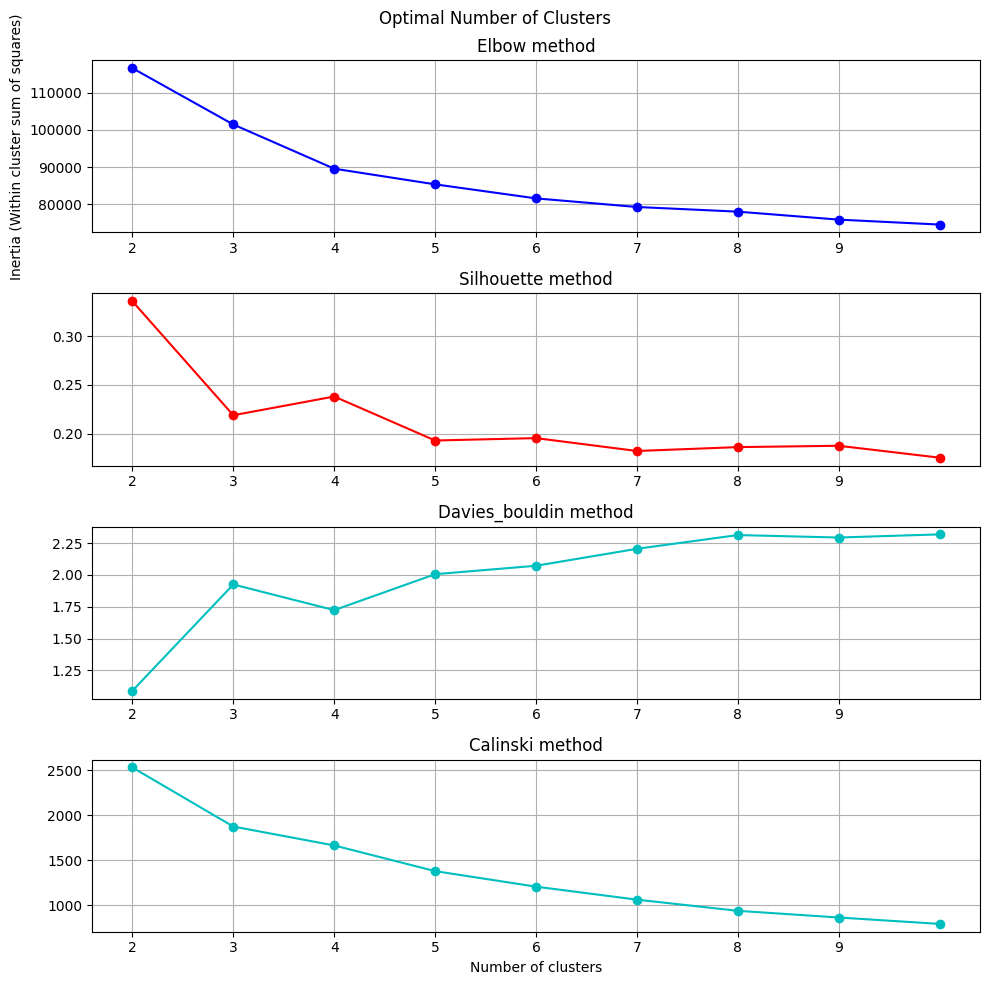

In [18]:
#plot inertials

fig,axes = plt.subplots(4,1,figsize=(10,10))
fig.suptitle('Optimal Number of Clusters')

axes[0].plot(range(2,11),inertias,linestyle='-', marker='o', color='b')
axes[0].set_title('Elbow method')
axes[0].grid(True)
#axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Inertia (Within cluster sum of squares)')
axes[0].set_xticks(range(2,10))

axes[1].plot(range(2,11),silhouette,linestyle='-', marker='o', color='r')
axes[1].set_title('Silhouette method')
axes[1].grid(True)
axes[1].set_xticks(range(2,10))
#axes[1].set_xlabel('Number of clusters')

axes[2].plot(range(2,11),dbi_scores,linestyle='-', marker='o', color='c')
axes[2].set_title('Davies_bouldin method')
axes[2].grid(True)
axes[2].set_xticks(range(2,10))
plt.tight_layout()


axes[3].plot(range(2,11),calinski_scrs,linestyle='-', marker='o', color='c')
axes[3].set_title('Calinski method')
axes[3].grid(True)
axes[3].set_xticks(range(2,10))
axes[3].set_xlabel('Number of clusters')
plt.tight_layout()
plt.show()

### Observations:
For the inertia, there is an elbow at 4, meaning there is a sharp decrease in inertial until 4 then it slows down.       

For silhouette, the closer the score is to 1 the better. There is an increase at 4 after which the score decreases.

For davies_bouldin measures the ratio of within cluster distances to distances between clusters.   
    - Below 0.5 is very good,  
    - between 0.5 and 0.7 is good,  
    - above 0.7 is means overlapping clusters  
    - There there is an obvious decrease at 4 after which the score increased
For Calinski-Harabasz Index:
    - There is a slight increase at 4 clusters then the values decrease
    
Conclusion: 4 clusters is the optimal number of clusters, however, I will try 4 and 5 clusters to see if 5 clusters add anything significant

### Add a feature with 4 clusters 
- fit kmeans to encoded data
- add a cluster_4 feature by using the .predict method on encoded data

In [19]:
kmeans_4 = KMeans(n_clusters= 4, random_state=42)
kmeans_4.fit(df_encoded)


KMeans(n_clusters=4, random_state=42)

### After getting clusters from kmeans, add the clusters to orginal unscaled df_train

In [20]:
#add clusters to orginal unscaled df_train
df_train['cluster_4'] = kmeans_4.predict(df_encoded)
df_train.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cluster_4
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,No,No,Yes,One year,No,Mailed check,64.85,1336.80,No,2
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No,3


#### Add 5 clusters to the data for comparison

In [23]:
kmeans_5 = KMeans(n_clusters= 5, random_state=42)
kmeans_5.fit(df_encoded)

#add clusters to orginal unscaled df_train
df_train['cluster_5'] = kmeans_5.predict(df_encoded)

In [24]:
df_train.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cluster_4,cluster_5
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,No,Yes,One year,No,Mailed check,64.85,1336.80,No,2,2
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No,3,4


#### Inertia improvement
- inertia is the within cluster sum of squares that kmeans tries to minimize
- inertia improvement measures how much the clustering solution improved by adding another cluster
- it is equal to the inertia from 4 clusters - inertia from 5 clusters / inertia from 4 clusters
- if it is higher than 15% then there is high improvement
- if it is below 5% then having 5 clusters is insignificant

In [25]:

improvement = ((kmeans_4.inertia_ - kmeans_5.inertia_) / kmeans_4.inertia_ )* 100
improvement

4.694579729210727

The inertia improvement is very small which suggests that 5 clusters do not explain the data better and the model could be overfitting to noise. 

### Print distribution of cases per cluster

In [26]:

print(f"Distribution of cases by 4 cluster: \n{(df_train.groupby('cluster_4')['customerID'].count()/df_train.shape[0])*100}")

print(f"Distribution of cases by 5 cluster: \n{(df_train.groupby('cluster_5')['customerID'].count()/df_train.shape[0])*100}")



Distribution of cases by 4 cluster: 
cluster_4
0     9.797657
1    21.547746
2    38.196663
3    30.457934
Name: customerID, dtype: float64
Distribution of cases by 5 cluster: 
cluster_5
0     9.797657
1    21.547746
2    25.683351
3    20.198793
4    22.772453
Name: customerID, dtype: float64


- Cluster 0 and 1 remain the same at almost 10% and 21%.
- clusters 2 and 3 in in 4 clusters are split into smaller segments:  
          - for 4 clusters: cluster 2=38% and 3 at 30% ==> for 5 clusters: 2 = 25%, 3 = 20% and 4 = 23%
- This shows that the split was not a simple bianary split and that there are a more complex distribution of data points between clusters.


## Calculate mean and median for each cluster by churn for numeric features 

- Create a df of all numeric cols for exploration

In [28]:
num_cols = ['tenure','MonthlyCharges','TotalCharges']

In [29]:
#copy numeric columns
num_df = df_train[num_cols].copy()
#group numeric columns by cluster
num_df['cluster_4'] = df_train['cluster_4']
num_df['cluster_5'] = df_train['cluster_5']
#churn needs to be numeric
num_df['Churn']=target
num_df.head()

,tenure,MonthlyCharges,TotalCharges,cluster_4,cluster_5,Churn
0,21,64.85,1336.80,2,2,0
1,54,97.20,5129.45,3,4,0
2,1,23.45,23.45,0,0,1
3,4,70.20,237.95,2,2,1
4,0,61.90,0.00,2,2,0


### Explore the numeric columns (tenure, monthlycharges, totalcharges) grouping them by clusters
- Calculate mean and median of the numeric columns

In [30]:
#calculate total mean of tenure, monthlycharges and totalcharges
mean_tenure = num_df['tenure'].mean()
median_tenure = num_df['tenure'].median()
mean_monthlycharges = num_df['MonthlyCharges'].mean()
median_monthlycharges = num_df['MonthlyCharges'].median()
mean_totalcharges = num_df['TotalCharges'].mean()
median_totalcharges = num_df['TotalCharges'].median()


In [31]:


#calculate mean by cluster_3
grouped_df_mean = num_df.drop('cluster_5', axis=1).groupby(['cluster_4','Churn']).mean().add_prefix('mean_')



#calculate median by cluster
grouped_df_median = num_df.drop('cluster_5', axis=1).groupby(['cluster_4','Churn']).median().add_prefix('median_')


#join the mean and median dfs by cluster to see if data is skewed
metric_df_4 = pd.concat([grouped_df_mean,grouped_df_median], axis=1)

metric_df_4

mean_tenure  mean_MonthlyCharges  mean_TotalCharges  \
cluster_4 Churn                                                        
0         0        37.269417            43.586165        1772.936044   
          1        16.064286            37.558214         687.746429   
1         0        32.012489            21.145094         695.391748   
          1         9.322581            20.459677         197.692473   
2         0        18.987069            70.184353        1360.335517   
          1        11.308468            77.850958         924.471976   
3         0        56.507266            90.807682        5165.924567   
          1        48.476015            98.760332        4800.639852   

                 median_tenure  median_MonthlyCharges  median_TotalCharges  
cluster_4 Churn                                                             
0         0               39.0                 43.650             1542.600  
          1                8.0                 35.825              269.525  
1         0               27.0                 20.150              571.750  
          1                2.0                 20.000               35.850  
2         0               16.0                 70.350             1130.425  
          1                7.0                 79.700              522.225  
3         0               61.0                 91.950             5215.100  
          1               50.0                101.500             4837.600

In [32]:

#calculate mean by cluster_5
grouped_df_mean = num_df.drop('cluster_4', axis=1).groupby(['cluster_5','Churn']).mean().add_prefix('mean_')



#calculate median by cluster
grouped_df_median = num_df.drop('cluster_4', axis=1).groupby(['cluster_5','Churn']).median().add_prefix('median_')


#join the mean and median dfs by cluster to see if data is skewed
metric_df_5 = pd.concat([grouped_df_mean,grouped_df_median], axis=1)

metric_df_5
#metrics = pd.concat([metric_df_3,metric_df_4],axis=0)
#metrics

mean_tenure  mean_MonthlyCharges  mean_TotalCharges  \
cluster_5 Churn                                                        
0         0        37.269417            43.586165        1772.936044   
          1        16.064286            37.558214         687.746429   
1         0        32.012489            21.145094         695.391748   
          1         9.322581            20.459677         197.692473   
2         0        17.772727            63.789432        1136.429602   
          1         7.894180            68.427337         552.333157   
3         0        34.845343            92.122056        3232.901670   
          1        22.811951            92.722496        2147.720914   
4         0        59.006055            90.033564        5366.064965   
          1        54.322835            97.911811        5376.562992   

                 median_tenure  median_MonthlyCharges  median_TotalCharges  
cluster_5 Churn                                                             
0         0               39.0                 43.650             1542.600  
          1                8.0                 35.825              269.525  
1         0               27.0                 20.150              571.750  
          1                2.0                 20.000               35.850  
2         0               14.0                 62.200              888.000  
          1                3.0                 70.700              223.150  
3         0               34.0                 93.600             3132.750  
          1               19.0                 94.250             1730.350  
4         0               64.0                 89.925             5519.250  
          1               58.0                103.700             5639.050

### Plot mean and median of each cluster and add the total mean and median for each feature to the graph for comparison

For 4 clusters


''

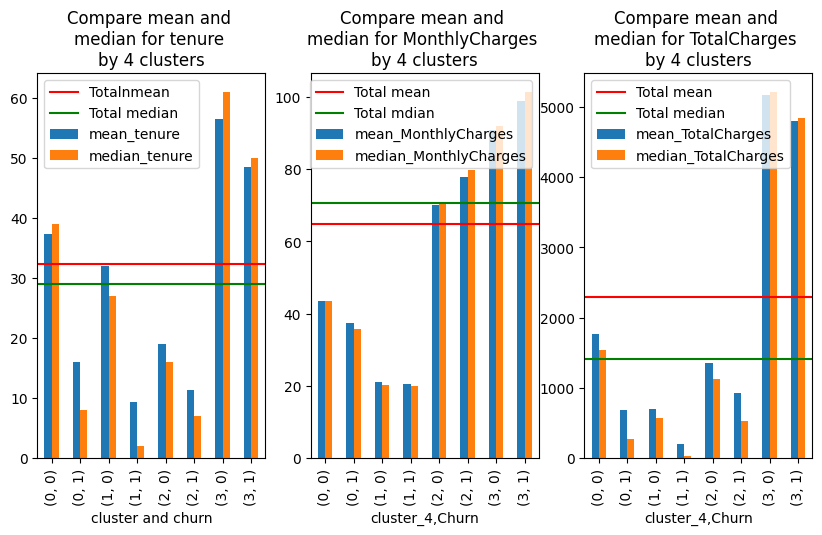

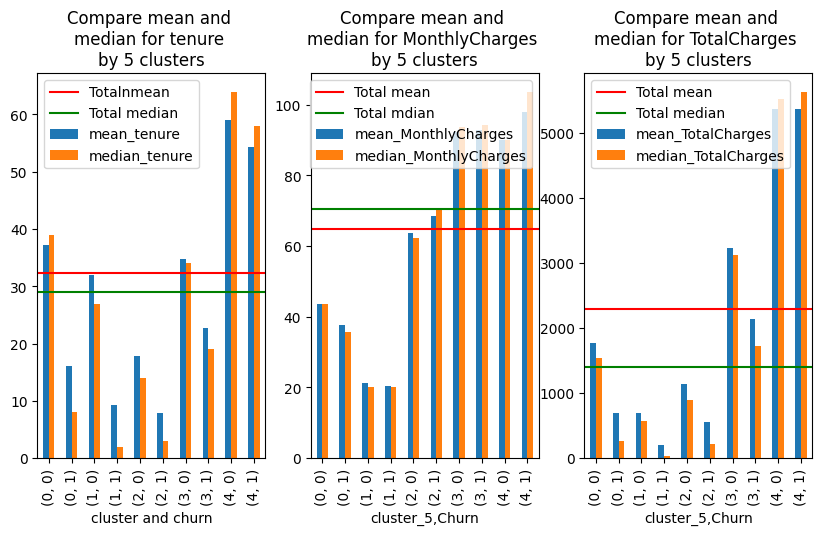

In [33]:


#plot
print('For 4 clusters')
f, ax = plt.subplots(1,3, figsize=(10,5))
#ax[0] = metric_df[['mean_tenure','median_tenure']].plot(metric_df['mean_tenure'],metric_df['median_tenure'], kind='bar')
metric_df_4[['mean_tenure','median_tenure']].plot(kind='bar', ax=ax[0])
ax[0].axhline(y=mean_tenure,c='r', label='Totalnmean')
ax[0].axhline(y=median_tenure,c='g', label='Total median')
ax[0].set_title('Compare mean and \nmedian for tenure \nby 4 clusters')
ax[0].set_xlabel('cluster and churn')
ax[0].legend(loc='best')

metric_df_4[['mean_MonthlyCharges','median_MonthlyCharges']].plot(kind='bar', ax=ax[1])
ax[1].set_title('Compare mean and \nmedian for MonthlyCharges \nby 4 clusters')
ax[1].axhline(y=mean_monthlycharges,c='r', label='Total mean')
ax[1].axhline(y=median_monthlycharges,c='g', label='Total mdian')
ax[1].legend()

metric_df_4[['mean_TotalCharges','median_TotalCharges']].plot(kind='bar', ax=ax[2]);
ax[2].set_title('Compare mean and \nmedian for TotalCharges \nby 4 clusters')
ax[2].axhline(y=mean_totalcharges,c='r', label='Total mean')
ax[2].axhline(y=median_totalcharges,c='g', label='Total median')

ax[2].legend(loc='best')

#plot mean/meadian for 5 clusters
f, ax = plt.subplots(1,3, figsize=(10,5))
#f.suptitle('For 4 Clusters\n\n')
#ax[0] = metric_df[['mean_tenure','median_tenure']].plot(metric_df['mean_tenure'],metric_df['median_tenure'], kind='bar')
metric_df_5[['mean_tenure','median_tenure']].plot(kind='bar', ax=ax[0])
ax[0].axhline(y=mean_tenure,c='r', label='Totalnmean')
ax[0].axhline(y=median_tenure,c='g', label='Total median')
ax[0].set_title('Compare mean and \nmedian for tenure \nby 5 clusters')
ax[0].set_xlabel('cluster and churn')
ax[0].legend(loc='best')

metric_df_5[['mean_MonthlyCharges','median_MonthlyCharges']].plot(kind='bar', ax=ax[1])
ax[1].set_title('Compare mean and \nmedian for MonthlyCharges \nby 5 clusters')
ax[1].axhline(y=mean_monthlycharges,c='r', label='Total mean')
ax[1].axhline(y=median_monthlycharges,c='g', label='Total mdian')
ax[1].legend()

metric_df_5[['mean_TotalCharges','median_TotalCharges']].plot(kind='bar', ax=ax[2]);
ax[2].set_title('Compare mean and \nmedian for TotalCharges \nby 5 clusters')
ax[2].axhline(y=mean_totalcharges,c='r', label='Total mean')
ax[2].axhline(y=median_totalcharges,c='g', label='Total median')

ax[2].legend(loc='best')

;

- calculate the % of churn/not churn for each of the 4 clusters

In [34]:
total_per_cluster = num_df.drop('cluster_5', axis=1).groupby(['cluster_4'])[['Churn']].count()
perc_churn = num_df.drop('cluster_5', axis=1).groupby(['cluster_4','Churn'])[['Churn']].count()/total_per_cluster * 100
perc_churn

Churn
cluster_4 Churn           
0         0      74.637681
          1      25.362319
1         0      92.339374
          1       7.660626
2         0      53.903346
          1      46.096654
3         0      84.207459
          1      15.792541

### plot distribution of each cluster comparing churn/not churn using box plots and violin plots

In [35]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

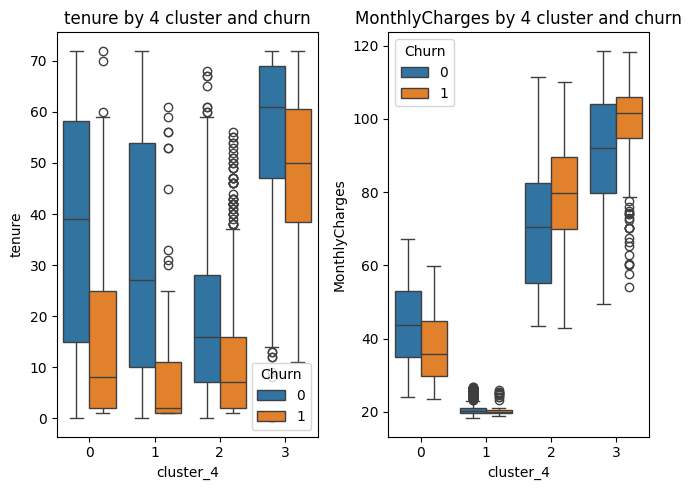

In [36]:

plt.figure(figsize = (10,5))
for i, col in enumerate(num_cols[:-1]):
    plt.subplot(1,3,i+1)
    sns.boxplot(x='cluster_4', y=col, hue = 'Churn', data=num_df)
    plt.title(f'{col} by 4 cluster and churn')
plt.tight_layout()

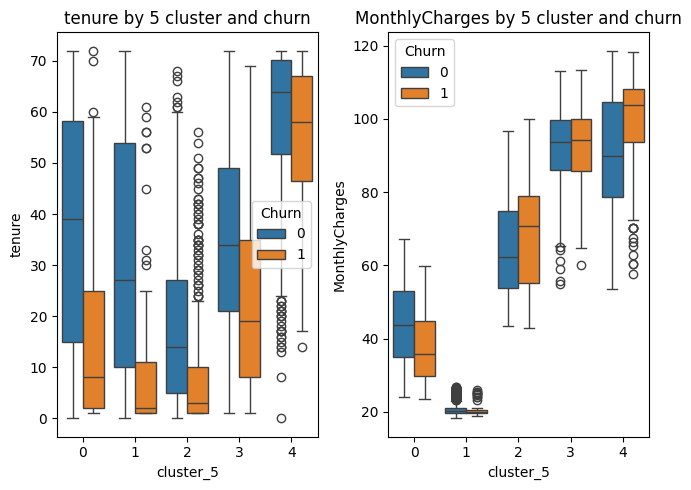

In [37]:
plt.figure(figsize = (10,5))
for i, col in enumerate(num_cols[:-1]):
    plt.subplot(1,3,i+1)
    sns.boxplot(x='cluster_5', y=col, hue = 'Churn', data=num_df)
    plt.title(f'{col} by 5 cluster and churn')
plt.tight_layout()

- Calculate the percentage of churn for each cluster

In [38]:

total_per_cluster = num_df.drop('cluster_5', axis=1).groupby(['cluster_4'])[['Churn']].count()
perc_churn = num_df.drop('cluster_5', axis=1).groupby(['cluster_4','Churn'])[['Churn']].count()/total_per_cluster * 100
perc_churn


Churn
cluster_4 Churn           
0         0      74.637681
          1      25.362319
1         0      92.339374
          1       7.660626
2         0      53.903346
          1      46.096654
3         0      84.207459
          1      15.792541

In [39]:
#calculate percentage of churned customers by cluster
total_per_cluster = num_df.drop('cluster_4', axis=1).groupby(['cluster_5'])[['Churn']].count()
perc_churn = num_df.drop('cluster_4', axis=1).groupby(['cluster_5','Churn'])[['Churn']].count()/total_per_cluster * 100
perc_churn

Churn
cluster_5 Churn           
0         0      74.637681
          1      25.362319
1         0      92.339374
          1       7.660626
2         0      60.815480
          1      39.184520
3         0      50.000000
          1      50.000000
4         0      90.101325
          1       9.898675

### Observations
There does not seem to be any benefit to splitting the data into 5 clusters, 4 clusters give better separation and does not ever fit the data

#### Clusters:
- Segment 0 are high risk customers with churn at 25%
    - They leave despite their low monthly charges
    - This segement needs to be explored why these customers leave
- Segment 1 have 8% churn rate and represents value conscious loyal customers becuase these customers spend less than average but show strong loyalty, suggesting they're getting good value from basic or lower-tier services.
    - However, the churned customers in this segment have below average tenure so they are in a high risk initial window, if these customers get past this window they become loyal.
    - This segment shows that high spending is not neccessary for customer retention
    - These customers value their current lower cost and upselling them might not be recommended
- Segment 2 represents highes risk customers with 46% risk rate
    - High tenure combined high monthly charges shows these customers feel they are paying too much and not getting value
    - This segment is top priority for intervention
- Segment 3 is the most valuable customers, they have the highest tenure, monthlyCharges and totalCharges, with 15% churn. This segment represent high value customers and can be used as a model for the ideal customer profile.
    - Focus retention efforts on keeping these customers happy
    - Study what makes this segment successful to try to move customers from other segments into this one
    - Consider VIP programs or premium offerings specifically for this segment

- Drop cluster_5 since it is not useful

In [40]:
df_train = df_train.drop('cluster_5', axis=1)
df_train.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cluster_4
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,No,No,Yes,One year,No,Mailed check,64.85,1336.80,No,2
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No,3


### Explore clusters
- Create summary stats for numerical values grouped by cluster and churn

In [41]:
def mean_median_diff(ser):
    '''
    returns a series' mean - median
    ''' 
    return ser.mean()-ser.median()
            



In [43]:
summary_df = num_df.groupby(['cluster_4','Churn'])[num_cols].agg(['mean','median',mean_median_diff,'std'])

summary_df

tenure                                    MonthlyCharges  \
                      mean median mean_median_diff        std           mean   
cluster_4 Churn                                                                
0         0      37.269417   39.0        -1.730583  23.239633      43.586165   
          1      16.064286    8.0         8.064286  18.270632      37.558214   
1         0      32.012489   27.0         5.012489  23.973755      21.145094   
          1       9.322581    2.0         7.322581  14.995768      20.459677   
2         0      18.987069   16.0         2.987069  14.788028      70.184353   
          1      11.308468    7.0         4.308468  12.087205      77.850958   
3         0      56.507266   61.0        -4.492734  14.690934      90.807682   
          1      48.476015   50.0        -1.523985  15.046544      98.760332   

                                                     TotalCharges            \
                  median mean_median_diff        std         mean    median   
cluster_4 Churn                                                               
0         0       43.650        -0.063835  11.407266  1772.936044  1542.600   
          1       35.825         1.733214  10.030301   687.746429   269.525   
1         0       20.150         0.995094   2.212056   695.391748   571.750   
          1       20.000         0.459677   1.582964   197.692473    35.850   
2         0       70.350        -0.165647  16.019488  1360.335517  1130.425   
          1       79.700        -1.849042  15.781561   924.471976   522.225   
3         0       91.950        -1.142318  15.428921  5165.924567  5215.100   
          1      101.500        -2.739668  11.825263  4800.639852  4837.600   

                                               
                mean_median_diff          std  
cluster_4 Churn                                
0         0           230.336044  1342.005492  
          1           418.221429   888.132452  
1         0           123.641748   550.249362  
          1           161.842473   319.683675  
2         0           229.910517  1106.598866  
          1           402.246976  1016.581037  
3         0           -49.175433  1711.229025  
          1           -36.960148  1659.150236

As tenure increases churn decreases which further suggests that tenure is inversely related to churn, so the longer a customer stays the less likely they will churn

### Influence of numeric features (tenure, MonthlyCharges, Total_charges

* To check if there are statistically significant differences in tenure, monthlycharges and totalcharges between churned and non churned customers, perform a t-test and a Mann-Whitney U test.  
* Mann-Whitney U test is a non-parametric test to determine if two samples come from the same distribution, unlike t-test, it does not assume that distributions are normal which makes it suitable for data that is skewed or has outliers because it compares the rank of values instead of the values themselves, which is the case here. The two distributions are going to be for churned and unchurned customers. If p < 0.05 then there is a significant difference

- Perform ttest

In [137]:

df_train[df_train['cluster_4'] == 3]['Churn']=='Yes'

1       False
13      False
16      False
17      False
21      False
        ...  
5613    False
5624     True
5625    False
5627    False
5630    False
Name: Churn, Length: 1716, dtype: bool

### Perform stats tests to calculate the t score to see if in cluster distribution is significant

In [48]:
from scipy.stats import ttest_ind, mannwhitneyu

def perform_stat_test(df, cluster_no, features = ['tenure','MonthlyCharges','TotalCharges']):
    '''
    perform t-test and a Mann Whitney U test
    '''
    print('_'*50)
    print(f'\nTest for cluster: {cluster_no}')

    #separate data by cluster
    cluster_df = df[df['cluster_4'] == cluster_no]
    
    #separate churned/not churned
    churned = cluster_df[cluster_df['Churn'] == 'Yes']
    not_churned = cluster_df[cluster_df['Churn'] == 'No']

    for feature in features:
        #ttest
        t_stat, p_val = ttest_ind(churned[feature],not_churned[feature], equal_var=False) #does not assume equal population variance
        print(f'\nFor feature {feature}')
        print(f"t-test: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
        print(f"Significant difference in means: {'Yes' if p_val < 0.05 else 'No'}")
        #mann whiney
        t_stat, p_val  = mannwhitneyu(churned[feature],not_churned[feature],alternative='two-sided')
        print(f"Mann Whitney U test: U-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
        print(f"Significant difference in means: {'Yes' if p_val < 0.05 else 'No'}")
for i in range(4):
    perform_stat_test(df_train, i)

__________________________________________________

Test for cluster: 0

For feature tenure
t-test: t-statistic = -11.0311, p-value = 0.0000
Significant difference in means: Yes
Mann Whitney U test: U-statistic = 13327.5000, p-value = 0.0000
Significant difference in means: Yes

For feature MonthlyCharges
t-test: t-statistic = -5.9267, p-value = 0.0000
Significant difference in means: Yes
Mann Whitney U test: U-statistic = 20153.0000, p-value = 0.0000
Significant difference in means: Yes

For feature TotalCharges
t-test: t-statistic = -10.8489, p-value = 0.0000
Significant difference in means: Yes
Mann Whitney U test: U-statistic = 13593.0000, p-value = 0.0000
Significant difference in means: Yes
__________________________________________________

Test for cluster: 1

For feature tenure
t-test: t-statistic = -13.2540, p-value = 0.0000
Significant difference in means: Yes
Mann Whitney U test: U-statistic = 19452.0000, p-value = 0.0000
Significant difference in means: Yes

For feature Mo

- Consistant significant result for all three freatures ==> there is strong evidence that the feature differs between churned and non-churned customers for each cluster


- Save data 

In [51]:
df_train.to_csv('data/train_data_with_cluster.csv', index=False)